## Vision Project


In [1]:
import torch, random, lab_utils, classify_utils
import numpy as np
from sklearn.metrics import classification_report
reload(classify_utils)
from lab_utils import UnNormalize
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
import torchvision.utils as utils
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import os as os
import os.path
from PIL import Image
import json, string
%matplotlib inline

### Custom Data Loader Methods

* Need ability to train on either manufacturer or family

In [2]:
def family_index():
    with open("./aircraft/data/families.txt") as f:
        dat = f.readlines()
    for i in range(len(dat)):
        dat[i] = dat[i].replace('\n','')
    return dat

def manufacturer_index():
    with open("./aircraft/data/manufacturers.txt") as f:
        dat = f.readlines()
    for i in range(len(dat)):
        dat[i] = dat[i].replace('\n','')
    return dat

# from PyTorch GitHub:  https://github.com/pytorch/vision/issues/81  

def default_loader(path):
    return Image.open(path).convert('RGB')

def default_flist_reader(flist):
    imlist = []
    fams = family_index()
    mfctrs = manufacturer_index()
    with open(flist, 'r') as rf:
        for line in rf.readlines():
            impath, imlabel = line.strip().split()
            imlist.append( ((''.join([impath,'.jpg'])), fams.index(imlabel)) )
    return imlist

class ImageFilelist(data.Dataset):
    def __init__(self, root, flist, transform=None, target_transform=None, 
                 flist_reader=default_flist_reader, loader=default_loader):
        self.root   = root
        self.imlist = flist_reader(flist)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        impath, target = self.imlist[index]
        img = self.loader(os.path.join(self.root,impath))
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self):
        return len(self.imlist)

### Training, Validation, and Testing Sets

In [3]:
train_loader = torch.utils.data.DataLoader(
    ImageFilelist(root="./aircraft/data/images/", flist="./aircraft/data/images_family_train.txt",
    transform=transforms.Compose([transforms.Scale(256),
                                  transforms.RandomSizedCrop(224),
                                  transforms.ToTensor()
    ])), batch_size=64, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(
    ImageFilelist(root="./aircraft/data/images/", flist="./aircraft/data/images_family_val.txt",
    transform=transforms.Compose([transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])), batch_size=64, shuffle=False, num_workers=1)

'''
test_loader = torch.utils.data.DataLoader(
    ImageFilelist(root="./aircraft/data/images/", flist="./aircraft/data/images_family_test.txt",
    transform=transforms.Compose([transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])), batch_size=64, shuffle=False, num_workers=1)
'''

test_loader = torch.utils.data.DataLoader(
    ImageFilelist(root="./aircraft/data/images/", flist="./aircraft/data/images_family_test.txt",
    transform=transforms.Compose([transforms.Scale((256,256)),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor()
    ])), batch_size=4, shuffle=False, num_workers=1)

### Train Model:  Definition

In [4]:
def train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        
        scheduler.step()
        
        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            #max_k_scores, max_k_labels = torch.topk(outputs.data,3)
            #correct += (labels.data.view(-1,1) == max_k_labels).sum()
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            counter += inputs.size(0)
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)   

#### Dataset and Network Definition

In [ ]:
classes = 70

# Definition of our network.
network = models.alexnet(pretrained=True)
for param in network.parameters():
      param.requires_grad = False
# replace final layer to predict 70 families
mod = list(network.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 1024))
mod.append(torch.nn.Linear(1024, classes))
new_classifier = torch.nn.Sequential(*mod)
network.classifier = new_classifier

learningRate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr = learningRate, weight_decay = 0.001, momentum=0.9)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,9,15],gamma=0.2);
train_model(network, criterion, optimizer, scheduler, train_loader, val_loader, n_epochs = 10, use_gpu = False)

#### Validation Loss and Accuracy (Model Selection)

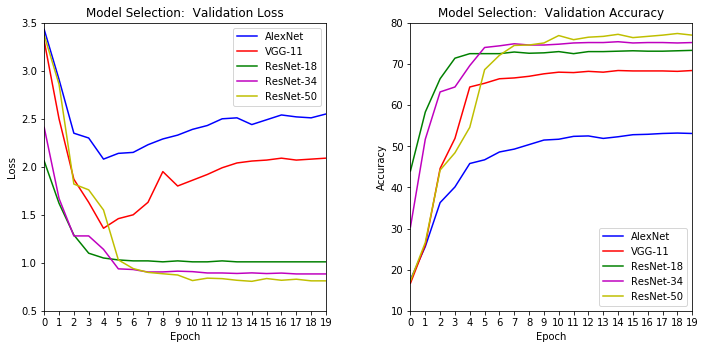

In [5]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [3.43,2.91,2.35,2.3,2.08,2.14,2.15,2.23,2.29,2.33,2.39,2.43,2.5,2.51,2.44,2.49,2.54,2.52,2.51,2.55],'b-',label='AlexNet')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [3.31,2.5,1.87,1.63,1.36,1.46,1.5,1.63,1.95,1.8,1.86,1.92,1.99,2.04,2.06,2.07,2.09,2.07,2.08,2.09],'r-',label='VGG-11')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [2.06,1.62,1.29,1.1,1.05,1.03,1.02,1.02,1.01,1.02,1.01,1.01,1.02,1.01,1.01,1.01,1.01,1.01,1.01,1.01],'g-',label='ResNet-18')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [2.41,1.67,1.28,1.28,1.14,.937,.93,.904,.905,.913,.908,.894,.894,.889,.895,.888,.893,.884,.884,.884],'m-',label='ResNet-34')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [3.37,2.86,1.82,1.76,1.55,1.03,.94,.9,.886,.873,.815,.84,.835,.818,.807,.836,.818,.829,.812,.812],'y-',label='ResNet-50')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Selection:  Validation Loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.axis([0,19,0.5,3.5])
plt.legend()

plt.subplot(122)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [17.6,25.6,36.3,40.1,45.8,46.7,48.6,49.3,50.4,51.5,51.7,52.4,52.5,51.9,52.3,52.8,52.9,53.1,53.2,53.1],'b-',label='AlexNet')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [16.7,26,44.6,51.9,64.4,65.3,66.4,66.6,67,67.6,68,67.9,68.2,68,68.4,68.3,68.3,68.3,68.2,68.4],'r-',label='VGG-11')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [44,58.3,66.4,71.4,72.5,72.5,72.5,72.9,72.6,72.7,73,72.5,73,73,73.1,73.2,73.1,73.1,73.2,73.3],'g-',label='ResNet-18')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [30.4,51.7,63.2,64.4,69.6,74,74.4,74.9,74.6,74.6,74.8,75.1,75.2,75.2,75.4,75.1,75.2,75.2,75.1,75.2],'m-',label='ResNet-34')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [17.3,26.6,44.2,48.4,54.6,68.6,72.1,74.5,74.6,75.1,76.9,75.9,76.5,76.7,77.2,76.4,76.7,77,77.4,77],'y-',label='ResNet-50')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Selection:  Validation Accuracy')
plt.axis([0,19,10,80])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.subplots_adjust(top=1, bottom=0, left=0, right=1.5, hspace=0.35, wspace=0.3)
plt.legend()
plt.show()

#### Results of Fine-Tuning

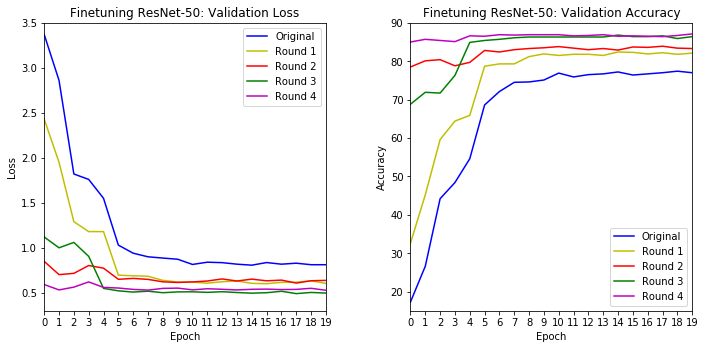

In [3]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [3.37,2.86,1.82,1.76,1.55,1.03,.94,.9,.886,.873,.815,.84,.835,.818,.807,.836,.818,.829,.812,.812],'b-',label='Original')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [2.43,1.95,1.29,1.18,1.18,.696,.689,.684,.638,.62,.619,.607,.623,.631,.605,.601,.616,.618,.633,.604],'y-',label='Round 1')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [.849,.702,.716,.803,.774,.65,.66,.649,.622,.615,.621,.631,.654,.631,.652,.633,.641,.608,.634,.638],'r-',label='Round 2')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [1.12,1,1.06,.905,.549,.522,.508,.518,.501,.51,.511,.505,.512,.503,.496,.501,.517,.491,.504,.497],'g-',label='Round 3')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [.592,.532,.563,.621,.56,.553,.538,.53,.549,.552,.533,.545,.539,.532,.539,.541,.536,.538,.55,.528],'m-',label='Round 4')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Finetuning ResNet-50: Validation Loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.axis([0,19,0.3,3.5])
plt.legend()

plt.subplot(122)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [17.3,26.6,44.2,48.4,54.6,68.6,72.1,74.5,74.6,75.1,76.9,75.9,76.5,76.7,77.2,76.4,76.7,77,77.4,77],'b-',label='Original')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [32.6,45.2,59.6,64.4,65.9,78.7,79.3,79.3,81.2,81.9,81.5,81.8,81.8,81.5,82.4,82.3,81.9,82.2,81.8,82.1],'y-',label='Round 1')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [78.5,80.1,80.4,78.8,79.7,82.8,82.4,83,83.3,83.5,83.8,83.4,83,83.3,82.9,83.7,83.6,83.9,83.4,83.3],'r-',label='Round 2')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [68.8,71.9,71.7,76.3,84.9,85.4,85.7,86.1,86.3,86.3,86.3,86.3,86.3,86.3,86.8,86.4,86.4,86.6,85.9,86.4],'g-',label='Round 3')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
         [85,85.7,85.4,85.1,86.6,86.5,86.9,86.8,86.9,86.9,86.9,86.6,86.7,86.9,86.5,86.6,86.5,86.4,86.7,87.1],'m-',label='Round 4')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Finetuning ResNet-50: Validation Accuracy')
plt.axis([0,19,15,90])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.subplots_adjust(top=1, bottom=0, left=0, right=1.5, hspace=0.35, wspace=0.3)
plt.legend()
plt.show()

#### Testing

In [ ]:
def test_model(network, criterion, testLoader, use_gpu = False, top_n = 1):
# Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    counter = 0.0
    class_frq = [1]*70
    class_acc = [0]*70
    t = tqdm(testLoader, desc = 'Testing Model')
    network.eval()  # This is important to call before evaluating!
    for (i, (inputs, labels)) in enumerate(t):

        # Wrap inputs, and targets into torch.autograd.Variable types.
        inputs = Variable(inputs)
        labels = Variable(labels)
            
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Forward pass:
        outputs = network(inputs)
        loss = criterion(outputs, labels)

        # logging information.
        counter += inputs.size(0)
        cum_loss += loss.data[0]
        #max_k_scores, max_k_labels = torch.topk(outputs.data,top_n)
        #correct += (labels.data.view(-1,1) == max_k_labels).sum()
        max_scores, max_labels = outputs.data.max(1)
        correct += (max_labels == labels.data).sum()
        for i in range(len(max_labels)):
            class_frq[labels.data[i]] += 1
            if labels.data[i] == max_labels[i]:
                class_acc[labels.data[i]] += 1
        t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        print([float(x)/float(y) for x, y in zip(class_acc, class_frq)])
        print(family_index())
    return (class_frq, class_acc)

# load the saved model
network = torch.load('resnet50_rescale_finetune_3.pth', map_location=lambda storage, loc: storage)
criterion = nn.CrossEntropyLoss()

# test top-1 accuracy
class_frq, class_acc = test_model(network, criterion, test_loader, use_gpu = False, top_n = 1)
# test top-3 accuracy
test_model(network, criterion, test_loader, use_gpu = False, top_n = 3)
# test top-5 accuracy
test_model(network, criterion, test_loader, use_gpu = False, top_n = 5)

#### Classification Report

_matplotlib wrapper code obtained from https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report_

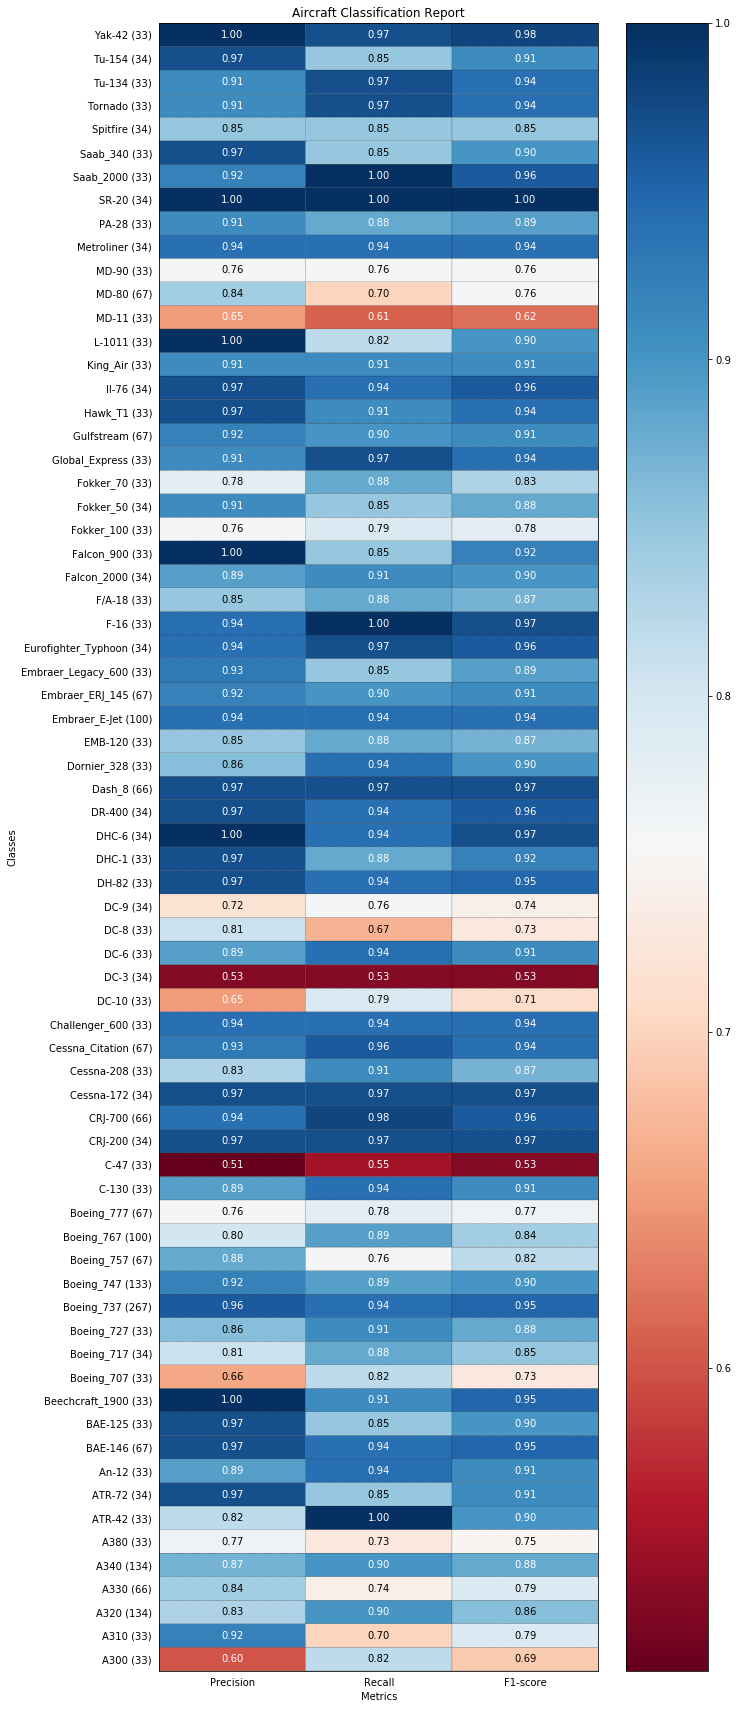

In [55]:
# use sklearn's "classification report" module 
# plotted using wrapper code from https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
y_true = y_preds = []
with open("test_actual.txt","r") as f:
    for line in f:
        y_true.append(int(line.strip()))
with open("test_predictions.txt","r") as f:
    for line in f:
        y_preds.append(int(line.strip()))      
classify_utils.plot_classification_report(classification_report(np.array(y_true), np.array(y_preds), target_names=class_name), title='Aircraft Classification Report')


#### Example Classifications (test set)


Image 886


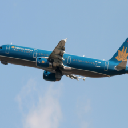

Image predicted as A320 with confidence 0.87
Actual class is A320

Image 3265


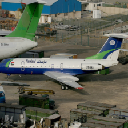

Image predicted as A340 with confidence 0.46
Actual class is Tu-134

Image 1053


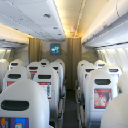

Image predicted as BAE-146 with confidence 0.87
Actual class is A340

Image 1398


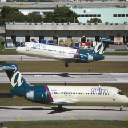

Image predicted as Boeing_717 with confidence 0.79
Actual class is Boeing_717

Image 353


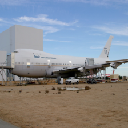

Image predicted as Boeing_747 with confidence 0.47
Actual class is Boeing_747

Image 113


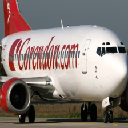

Image predicted as Boeing_777 with confidence 0.62
Actual class is Boeing_737

Image 3219


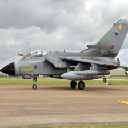

Image predicted as Tornado with confidence 1.00
Actual class is Tornado

Image 2872


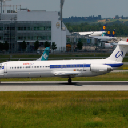

Image predicted as DC-9 with confidence 0.44
Actual class is MD-80

Image 727


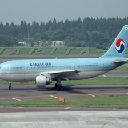

Image predicted as A300 with confidence 0.69
Actual class is A300

Image 1381


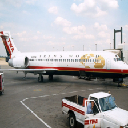

Image predicted as Fokker_100 with confidence 0.82
Actual class is Boeing_717


In [4]:
# network
network = torch.load('resnet50_rescale_finetune_3.pth', map_location=lambda storage, loc: storage)

# Randomly select 5 images from the validation set
network.eval()

# test images
test_data = ImageFilelist(root="./aircraft/data/images/", flist="./aircraft/data/images_family_test.txt",
                          transform=transforms.Compose([transforms.Scale((256,256)),
                                                        transforms.CenterCrop(224),
                                                        transforms.ToTensor()]))

# class names
classes = family_index()

# Now predict the category using this trained classifier
for i in range(0, 10):
    img_id = random.randint(0, 3333) # 3333 images in this validation set
    print('\nImage %d' % img_id)
    img, lbl = test_data[img_id]
    predictions = F.softmax(network(Variable(img.unsqueeze(0))))
    predictions = predictions.data

    # Show the results of the classifier.
    lab_utils.show_image(lab_utils.tensor2pil(img).resize((128, 128)));
    max_score, max_label = predictions.max(1)
    print('Image predicted as %s with confidence %.2f\nActual class is %s' % (classes[max_label[0]], max_score[0], classes[lbl]))

    # Print out detailed predictions.
    #for (i, pred) in enumerate(predictions.squeeze().tolist()):
    #    print('y_hat[%s] = %.2f' % (classes[i], pred))

#### Classify manually-provided images from the Internet (not in our dataset)

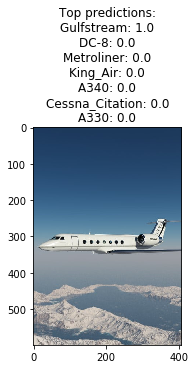

In [3]:
# saved network
network = torch.load('resnet50_rescale_finetune_2_copy3.pth', map_location=lambda storage, loc: storage)
network1 = torch.load('resnet50_rescale_finetune_2_copy2.pth', map_location=lambda storage, loc: storage)

# network eval
network.eval()
network1.eval()

# class names
classes = family_index()

# image from the internet (simulating a user-provided photo)
image = Image.open('hand_test/gulfstream.jpg').convert('RGB')
preprocessFn = transforms.Compose([transforms.Scale((256,256)), 
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor()])
inputVar = Variable(preprocessFn(image).unsqueeze(0))
predictions = network(inputVar)
predictions1 = network1(inputVar)

# top N classes
n = 8
probs, indices = (-F.softmax(predictions)).data.sort()
probs1, indices1 = (-F.softmax(predictions1)).data.sort()
probs = (-probs).numpy()[0][:n]; indices = indices.numpy()[0][:n]
probs1 = (-probs1).numpy()[0][:n]; indices1 = indices1.numpy()[0][:n]
preds = [classes[idx] + ':  ' + '%.3f' % prob for (prob, idx) in zip(probs, indices)]
preds1 = [classes[idx] + ':  ' + '%.3f' % prob for (prob, idx) in zip(probs1, indices1)]

preds_dict = {classes[idx]:'%.3f' % prob for (prob, idx) in zip(probs, indices)}
preds1_dict = {classes[idx]:'%.3f' % prob for (prob, idx) in zip(probs1, indices1)}

results = {}
for key, val in preds_dict.iteritems():
    if key in preds1_dict.keys():
        results[key] = (float(preds1_dict[key]) + float(val)) / 2

import operator
results = sorted(results.items(), key=operator.itemgetter(1), reverse=True)
out = []
for i in results:
    out.append(str(i[0]) + ': ' + str(i[1]))


plt.title('Top predictions:\n' + string.join(out, '\n'))
        
# 5. Show image and predictions
#plt.title('Top ' + str(n) + ' predictions:\n' + string.join(preds, '\n'))
#print('Top ' + str(n) + ' predictions:\n' + string.join(preds1, '\n'))

plt.imshow(image);